In [ ]:
# Copyright 2024 Forusone(shins777@gmail.com)
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Gemini Multimodality - Marketing use cases.

* This colab simplified the original colab [intro_gemini_1_5_pro.ipynb](https://colab.sandbox.google.com/github/GoogleCloudPlatform/generative-ai/blob/main/gemini/getting-started/intro_gemini_1_5_pro.ipynb) for a workshop hands on lab.

* Understanding multimodal
  * [Image understanding](https://cloud.google.com/vertex-ai/generative-ai/docs/multimodal/image-understanding)
  * [Video understanding](https://cloud.google.com/vertex-ai/generative-ai/docs/multimodal/video-understanding)
  * [Audio understanding](https://cloud.google.com/vertex-ai/generative-ai/docs/multimodal/audio-understanding)
  * [Document understanding](https://cloud.google.com/vertex-ai/generative-ai/docs/multimodal/document-understanding)
  

## Set environment

### Install packages


In [2]:
%pip install --upgrade --quiet --user google-cloud-aiplatform

### Authentication to access to GCP (Colab only)

* Only for Colab in Google Drive
* No need to do this process if in Colab Enteprise on Vertex AI.


In [4]:
# To use markdown for output data from LLM
from IPython.display import display, Markdown

# Use OAuth to access the GCP environment.
import sys
if "google.colab" in sys.modules:
    from google.colab import auth
    auth.authenticate_user()

## Lab execution

### Define constants

In [5]:
PROJECT_ID = "ai-hangsik"  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}
MODEL_NAME = "gemini-1.5-flash-002" # @param {type:"string"}

### Import libraries

In [6]:
import vertexai

from vertexai.generative_models import (
    GenerationConfig,
    GenerativeModel,
    HarmBlockThreshold,
    HarmCategory,
    GenerationResponse,
    Tool,
    Part,
    ChatSession
)

from vertexai.preview.generative_models import grounding

### Initalize Vertex AI

In [7]:
# https://cloud.google.com/python/docs/reference/aiplatform/latest#initialization
vertexai.init(project=PROJECT_ID, location=LOCATION)

# https://cloud.google.com/vertex-ai/generative-ai/docs/reference/python/latest/vertexai.generative_models.GenerativeModel
model = GenerativeModel(MODEL_NAME)

### Helper functions for image processing.

In [39]:
import http.client
import typing
import urllib.request
import IPython.display
from vertexai.generative_models import GenerativeModel, Image, Part
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

def get_image_bytes_from_url(image_url: str) -> bytes:
    with urllib.request.urlopen(image_url) as response:
        response = typing.cast(http.client.HTTPResponse, response)
        image_bytes = response.read()
    return image_bytes

def load_image_from_url(image_url: str) -> Image:
    image_bytes = get_image_bytes_from_url(image_url)
    return Image.from_bytes(image_bytes)

# def display_content_as_video(content: str | Image | Part):
#     if not isinstance(content, Part):
#         return False
#     part = typing.cast(Part, content)
#     file_path = part.file_data.file_uri.removeprefix("gs://")
#     video_url = f"https://storage.googleapis.com/{file_path}"
#     IPython.display.display(IPython.display.Video(video_url, width=350))


def get_encoded_content_local(location, mime_type ):
  import base64

  """
  Get the encoded content object.

  location :
    The file location of the content.
  mime_type :
    The mime type of the content.

  Returns:
    The encoded content object.

  """

  content_obj = None

  with open(location, 'rb') as f:
    raw_obj = base64.b64encode(f.read()).decode('utf-8')
    content_obj = Part.from_data(data=base64.b64decode(raw_obj), mime_type=mime_type)

  return content_obj



### Helper function - Gemini Generation

In [31]:
def generate(contents:list,
             stream:bool) -> GenerationResponse:

    """
    Generate a response from the model.

    Args:
      contents : list
        query string to generate response
      stream : bool
        whether to stream the response

    Returns:
      GenerationResponse: The generated response.

    """

    # Request body
    #   https://cloud.google.com/vertex-ai/generative-ai/docs/model-reference/inference#request
    #   https://cloud.google.com/vertex-ai/generative-ai/docs/multimodal/send-multimodal-prompts#set_model_parameters
    generation_config = GenerationConfig(
        temperature=0.9,
        top_p=1.0,
        top_k=32,
        candidate_count=1,
        max_output_tokens=8192,
    )

    # Counts tokens
    print(f"Token Count : {model.count_tokens(contents)}")

    # Configure satey setting
    # : https://cloud.google.com/vertex-ai/generative-ai/docs/multimodal/configure-safety-attributes
    # : https://cloud.google.com/vertex-ai/generative-ai/docs/multimodal/configure-safety-attributes#how_to_remove_automated_response_blocking_for_select_safety_attributes
    safety_settings = {
        HarmCategory.HARM_CATEGORY_HARASSMENT: HarmBlockThreshold.BLOCK_LOW_AND_ABOVE,
        HarmCategory.HARM_CATEGORY_HATE_SPEECH: HarmBlockThreshold.BLOCK_LOW_AND_ABOVE,
        HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: HarmBlockThreshold.BLOCK_LOW_AND_ABOVE,
        HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_LOW_AND_ABOVE,
    }

    responses = model.generate_content(
        contents,
        generation_config=generation_config,
        safety_settings=safety_settings,
        stream=stream,
        tools= None
    )

    return responses


In [67]:
!ls

airplane.mp4  mz_marketing.jpg	mz_marketing.txt  sample_data


#### MZ Marketing image location
* https://github.com/shins777/google_gen_ai_sample/blob/main/contents/images/mz_article.jpeg
* ref : https://news.nate.com/view/20231228n07238

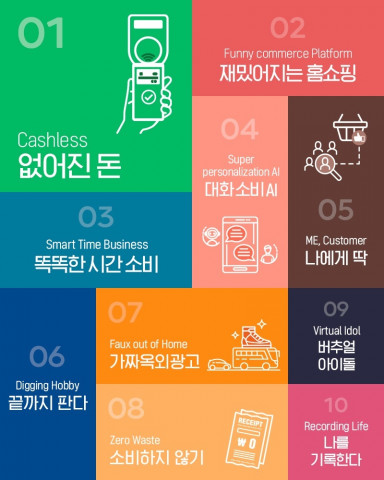

In [44]:
from IPython.display import Image

image_location = "mz_marketing.jpg"
mz_trend_image = get_encoded_content_local(image_location, "image/jpeg")

Image(image_location, width=400, height=500)

#### Airplane video location
* https://github.com/shins777/google_gen_ai_sample/blob/main/contents/videos/airplane.mp4


In [54]:


# Ref : https://prasadwilagama.hashnode.dev/how-to-add-playback-of-videos-to-google-colab-notebooks

import ipywidgets as widgets
from IPython.display import display

video_location = "./airplane.mp4"
video_widget = widgets.Video.from_file(video_location)

airplane_video = get_encoded_content_local(video_location, "video/mp4")

display(video_widget, width=10)

Video(value=b'\x00\x00\x00 ftypmp42\x00\x00\x00\x00mp42mp41isomavc1\x00\x00%\xa1moov\x00\x00\x00lmvhd\x00\x00\…

#### MZ marketing text location
* https://github.com/shins777/google_gen_ai_sample/blob/main/contents/text/mz_marketing.txt

In [58]:
text_location = "mz_marketing.txt"
with open(text_location, "r") as f:
    text_context = f.read()

display(Markdown(text_context))

최신 MZ 세대 마케팅 전략 : https://www.openads.co.kr/content/contentDetail?contsId=11361

커머스 기업이 MZ세대를 공략하는 것은 비즈니스의 성장과 발전에 있어서 매우 중요한 전략이죠. MZ 세대는 "밀레니얼(Millennials)"과 "Z 세대(Generation Z)"를 뜻하는 용어로 현재 대중을 이루고 있는 중요한 소비자 그룹이에요. 다양성과 유연성을 중요시하기 때문에 기성세대와는 다소 차이가 있어요. MZ 세대를 공략하기 위해서는 이들의 소비력과 관심사를 파악하고 효과적인 마케팅을 진행하는 것이 커머스에서 필수적 입니다! 

1. MZ 세대들의 새로운 소비 트렌드
우리가 흔히 알고 있던, ‘가성비’, ‘가심비’ 외에 새롭게 등장한 MZ 세대들의 소비 트렌드를 아시나요? 바로 미코노미인데요! 가격, 활용성 등 기타 다른 가치보다도 자신만의 기준에 따라 본인의 만족도를 최우선으로 하는 미코노미(Meconomy)가 요즘 MZ 세대들의 소비 트렌드라고 합니다.

미코노미, 그래서 뭔데?
미코노미는 ‘나(Me)’와 ‘경제(Economy)’를 합친 신조어에요. 내가 중심이 되어 나를 위한 소비에 돈을 아끼지 않는 트렌드를 말하죠. 개인의 취향과 가치가 소비의 기준이라니, 본인을 개성을 과감없이 드러내고 그것을 공유하는 MZ 세대의 특징에 걸맞는 소비 트렌드라고 볼 수 있죠. 이러한 소비 성향이 명품 시장을 키우기도 하고, 맨즈케어 시장을 확장하며 심지어 메타버스 세계 속 가상세계 붐을 일으키기도 했어요.🪐

가장 최근에는 MZ세대의 이러한 성향이 ‘미닝아웃’ 트렌드로 이어지고 있어요. 미닝아웃은 사실 미코노미 트렌드 중 하나라고 볼 수 있는데, ‘신념이 벽장 속에서 나온다’라는 뜻으로 Meaning+Coming out의 합성어에요. 즉, 개인의 취향과 정치/사회적 신념을 소비를 통해 적극적으로 표현하는 것을 말하죠. 논란이 발생한 기업은 불매운동을 통해 자신의 의지를 드러내고, 친환경 제품 혹은 착하고 바른 기업들은 ‘돈쭐’냄으로써 그들의 제품을 구매하고 매출을 증대시키기도 하는 게 대표적인 사례에요.

지그재그의 <제가 알아서 살게요> 캠페인
최근 MZ 타겟팅에 성공한 광고사례 중 대표적인 광고는 패션플랫폼 지그재그의 <내가 알아서 살게요> 캠페인이에요.👢 과거 시니어 광고모델인 윤여정 배우님을 모델로 기용하여 “니들 맘대로 하세요” 캠페인을 통한 파격적인 광고가 한차례 있었는데요, 그에 걸맞게 이번에는 “제가 알아서 살게요”라는 카피로 또 다른 시대흐름을 반영하는 카피가 나왔어요. “제가 알아서 살게요”는 알아서 살고(live), 알아서 사겠다(buy)는 중의적인 의미를 지낸 카피에요.✌🏻 지그재그의 브랜드 마케팅팀에 따르면 다양한 라이프 스타일을 갖고 있는 10대~30대 여성들을 타겟으로 스타일에는 답이 없고 어떤 스타일이든 존중한다'라는 가치를 확장하고자 했다고 해요.

이들이 이번 캠페인에 함께한 모델들도 크게 주목받았는데요, 그 원인은 모델 6명 모두 각기 다른 분야에 있는 사람들이지만 독보적인 캐릭터로 2030 여성들에게 아이코닉한 캐릭터라는 겁니다. 실제로 모델 채용 시 지그재그 측에서는 각자 뚜렷한 개성과 매력이 있으면서도 어떤 스타일이든 존중한다는 메시지를 가장 잘 표현할 모델들을 선정한 것이라고 해요. 👩‍👩‍👧 그만큼 각기 직업, 체형, 스타일이 달라 이들의 매력이 더 잘 표현됐다고 할 수 있죠.

광고는 모델들 뒤에서 그들을 평가하는 구설로 시작되는데요, 이 수근거림은 마지막에 웅성거림으로 처리되면서 모델의 얼굴을 줌인하고 그 때! “제가 알아서 살게요”라는 카피가 나와요. 😎 다양한 인생에 대해 존중없이 평가하고 참견하는 사람들에게 일침을 가한다는 점에서 인상 깊은 광고입니다.

이번 캠페인을 통해 브랜드 캠페인 시작 직후인 5월 중순 기준, 신규 가입자가 전주보다 43% 늘었고, 앱 설치도 26% 증가했다고 해요. 같은 기간 지그재그 첫 구매자 수도 51%나 늘었다고 해  ‘나 다움을 찾길 바란다’라는 브랜드 메시지가 명확하게 전달 된 결과이지 않을까 싶습니다. 👚

2. MZ 세대 공략을 위한 새로운 마케팅 전략 등장
특히나 MZ 세대는 디지털에 친숙하기에 기존의 마케팅 접근법과는 다른 특성들을 가지고 있어요. 이런 특성들을 바탕으로 온라인에서 기업의 브랜드 커뮤니케이션 역량을 강화하기 위한 다양한 노력들이 이어지고 있죠 더 나아가, 브랜드와의 상호 작용이 온라인에서 오프라인 분야까지 확장하며 다양한 전략들이 생겨나고 있어요. 우리 브랜드에 적절한 채널이 무엇인지 파악하고 MZ 세대의 특성을 적극적으로 활용하여 고객과 브랜드가 상호작용 해야 합니다.

소셜미디어를 적극 활용해보세요!
여러분 비즈니스에 가장 잘 맞는 온드미디어는 무엇인가요? SNS 플랫폼에 많은 시간을 보내는 것이 MZ 세대의 특성 중 하나인데요. 최근에는 짧은 영상을 통해 컨텐츠를 간결하고 빠르게 확인할 수 있는 숏폼 형태들이 새로운 트렌드로 자리를 잡았어요. 트렌드를 가득 담아 전달 드리는 만큼 이번 달 가장 핫한🔥스레드 소식도 간략하게 살펴볼까요?

스레드(Thread)란?
지난 7일, 메타에서 텍스트기반의 소셜 미디어 트위터의 대항마 스레드(Thread)를 출시했어요. 인스타그램과 손쉽게 연동을 할 수 있어서 폭발적으로 가입자가 증가했으며 무려 출시한 지 16시간만에 가입자가 3천만명 그리고 출시 5일 만에 이용자 1억명을 돌파하는 전례없는 기록을 세우기까지 했어요! 
하지만, 2주 연속 하락세에 이어 이용자가 약 70%로 줄어들었다고 합니다.😢 전문가들이 분석한 원인들 중 하나는 소통에 강점을 가지고 있지만, 다이렉트 메세지의 기능과 같은 주요 기능들이 빠졌기 때문이라는 견해가 있었어요.

기업의 소셜 미디어 활용 능력이 점차 발전하면서 새로운 소셜 미디어 마케팅 전략들도 등장했어요.

· 인플루언서 마케팅: MZ 세대에게 영향력을 지닌 인플루언서와의 협업을 통해 제품 혹은 브랜드를 소개하는 전략입니다. 인플루언서와 팔로워들 사이의 신뢰와 유대감을 활용하여 브랜드의 긍정적인 상호작용을 증진시킬 수 있어요. 또한 더 넓은 수요층을 대상으로 브랜드를 알릴 수 있어요.

· UGC(User Generated Contents) 활용: 소비자들이 브랜드와 제품을 직접 사용하고 경험한 내용을 제작하는 컨텐츠를 의미합니다. 용어는 생소할 수 있지만, #해시태그를 달고 경품 응모나 무료 음료수🧃 받아본 경험을 떠올려보세요! 블로그/인스타 체험단의 마케팅도 UGC를 활용한 대표적인 사례에요.

브랜드 놀이터🛝, 팝업 스토어

앞서 소개드린 사례들은 MZ 세대를 공략하기 위한 다양한 온라인 마케팅 사례라면, 최근에는 해당 영역이 오프라인까지 확대되어 브랜드의 새로운 컨셉이나 제품을 알리고 고객들을 끌어들이기 위해 팝업 스토어를 활용하는 사례가 늘고 있어요. 새롭고 재미있는 경험을 추구하는 MZ 세대를 겨냥하기에 가장 좋은 마케팅 활동이라고 생각해요! 팝업 스토어를 통해 사진을 찍거나 동영상을 촬영할 수 있는 장소를 제공하여 자연스럽게 UGC 활성화로 인한 온라인 홍보까지 이뤄낼 수 있는 일석이조🐰🐇의 전략이죠.

최근 팝업스토어에서 주목 받고 있는 컨셉은 레트로📺에요. 자신이 경험해보지 못한 과거 혹은 직접 경험해보지않았지만 마냥 즐거웠던 누군가의 추억을 통해 공감과 위로를 받으며 레트로의 개념 역시 새롭게 탄생해가고 있어요. 이런 레트로에도 종류가 있는거 알고 계셨나요?

· 레트로: Retrospect에서 유래한 단어로 회상, 회소, 추억을 의미해요. 쉽게 말해, 옛것을 그리워하고 따라하는 것을 뜻합니다. 빈티지한 옛것을 본떠 생산하는 것이 ‘레트로’라고 볼 수 있어요. ex) 더 퍼스트 슬램덩크🏀 영화, 필름 카메라🎞️

· 뉴트로: 뉴(New)+ 레트로(Retro)의 합성어에요. 레트로에 새로운 감성을 더해 재해석하는 것을 의미합니다. 성수동을 떠올리면 가장 와닿을 것 같아요. 구두 제조업 공장 혹은 자동차 정비소로 이용했던 낡은 건물의 외간과 그렇지 못한 세련된 내부로 이루어진 성수동 골목의 힙한 가게들이 대표적으로 뉴트로를 활용한 예시에요.

· Y2K: Year(연도) + 2(2000년) + Kilo(1,000)의 문제를 뜻하는 합성어로, 연도의 끝자리만 인식하는 컴퓨터 시스템의 오류로 2000년이 다가오면 1900년도와의 혼동이 있을거고, 2번째 밀레니엄을 맞이하면서 세계가 멸망할거라는 괴담이 도는 대혼란의 시기를 의미하는 용어에요. 그 혼란이 지나고 세기 말-세기 초의 파격적인 스타일이 쏟아 나왔던 시기였어요. 지금 재유행하는 크롭티, 로우라이즈, 벨벳 트레이닝 세트 등이 이 시기에 시작된 패션 아이템들이에요.

Article Source : https://www.openads.co.kr/content/contentDetail?contsId=11361


In [66]:

prompt = """
  당신은 마케터를 위한 마케팅 전략을 구축하는 데 도움을 주는 AI 에이전트입니다.

  1. 먼저 첨부된 비디오, 이미지, 텍스트에 대한 내용을 설명해주세요.
  2. 비디오, 이미지, 텍스트의 설명 내용을 참고해서 디지털 마케팅 광고 전략을 구축하세요.
  3. TV, 인쇄, 소셜 미디어와 같은 채널이나 미디어별로 마케팅 성과를 측정하는 방법을 고려하세요.

"""


stream = False

contents = [prompt, airplane_video, mz_trend_image,text_context]
responses = generate(contents, stream)

if stream:
  for response in responses:
    print(response.text, end="")
else:
  display(Markdown(responses.text))


Token Count : total_tokens: 11772
total_billable_characters: 3520



## 아비앙카 항공 디지털 마케팅 광고 전략

**1. 비디오, 이미지, 텍스트 내용 설명**

제공된 자료는 아비앙카 항공의 항공기 날개 사진과 MZ세대를 타겟으로 한 최신 마케팅 트렌드 및 전략에 대한 텍스트 자료로 구성되어 있습니다.  비디오는 구름 위를 비행하는 아비앙카 항공기의 날개를 촬영한 영상입니다.  이는 자유로움, 모험심, 새로운 경험에 대한 긍정적인 감정을 자극하는 시각적 요소로 활용될 수 있습니다.  텍스트 자료는 MZ세대의 소비 트렌드(미코노미, 미닝아웃), 지그재그의 성공적인 MZ세대 타겟팅 캠페인 사례, 그리고 소셜 미디어 마케팅 전략(인플루언서 마케팅, UGC 활용), 오프라인 마케팅 전략(팝업 스토어, 레트로 컨셉) 등을 상세히 설명하고 있습니다.


**2. 디지털 마케팅 광고 전략 구축**

아비앙카 항공은 비디오와 텍스트 자료를 바탕으로 MZ세대를 타겟으로 하는 다음과 같은 디지털 마케팅 광고 전략을 구축할 수 있습니다.

**목표:**  MZ세대의 아비앙카 항공 이용률 증대 및 브랜드 인지도 향상

**핵심 메시지:**  "당신의 개성을 담은 여행, 아비앙카와 함께하세요."

**전략:**

* **미코노미 및 미닝아웃 트렌드 반영:**  MZ세대의 개성 중시 및 가치 소비 트렌드를 반영하여, 아비앙카 항공을 통해 자신만의 특별한 여행 경험을 만들 수 있다는 점을 강조합니다.  여행 목적지의 다양성과 아비앙카 항공의 차별화된 서비스를 통해, 개인의 취향과 가치관을 반영한 여행을 제안합니다.  친환경적인 항공 운영 방식이나 사회공헌 활동 등을 부각하여 미닝아웃 트렌드를 적극 활용할 수 있습니다.

* **지그재그 캠페인 사례 분석 및 적용:**  지그재그의 성공적인 캠페인처럼 다양한 라이프스타일을 가진 MZ세대 모델을 기용하여, 아비앙카 항공의 다양한 여행 옵션과 목적지를 보여주는 광고를 제작합니다.  모델 선정 시,  여행을 즐기는 모습을 자연스럽게 표현할 수 있는 인플루언서를 고려합니다.

* **인플루언서 마케팅:**  여행, 사진, 영상 분야의 인플루언서와 협업하여 아비앙카 항공 이용 후기를 제작하고,  여행 관련 콘텐츠(숏폼 영상, 사진, 스토리 등)를 통해  자연스럽게 브랜드를 노출합니다.  인플루언서의 개성과 아비앙카 항공의 브랜드 이미지가 잘 어울리는 협업을 진행합니다.

* **UGC 활용:**  여행 관련 해시태그 이벤트 (사진/영상 공유 이벤트, 후기 이벤트)를 진행하여 소비자 참여를 유도하고,  UCC를 적극적으로 활용하여  자연스러운 브랜드 홍보를 진행합니다.  여행 사진 콘테스트,  여행 영상 제작 챌린지 등의 이벤트를 기획할 수 있습니다.

* **소셜 미디어 광고:**  인스타그램, 페이스북, 틱톡, 유튜브 등의 플랫폼을 활용하여 타겟 고객에게 맞춤형 광고를 진행합니다.  아비앙카 항공의 고품질 비디오, 목적지 사진 등 시각적인 요소를 활용하여  높은 참여율을 유도합니다.  스레드와 같은 새로운 플랫폼도 적극적으로 활용하는 것을 고려합니다.  단, 스레드의 단점(다이렉트 메시지 기능 부족 등)을 고려하여 다른 플랫폼과의 연계 전략을 세웁니다.

* **팝업 스토어:**  아비앙카 항공의 브랜드를 체험할 수 있는 팝업 스토어를 운영합니다.  레트로 컨셉을 활용하여  새롭고 독특한 경험을 제공합니다.  팝업 스토어에서 촬영한 사진과 영상을 소셜 미디어에 공유하도록 유도하여 UGC를 생성합니다.


**3. 미디어별 마케팅 성과 측정**

* **TV:** 시청률, 광고 노출 횟수, 브랜드 인지도 조사, 웹사이트 방문자 수 증가 추이 분석
* **인쇄:** 광고 게재 매체의 독자 수, 쿠폰 사용률, 문의 전화 수, 웹사이트 방문자 수 증가 추이 분석
* **소셜 미디어:** 게시물 좋아요 수, 댓글 수, 공유 수, 계정 팔로워 수 증가, 웹사이트 트래픽, 전환율 (예약 건수, 앱 다운로드 수), 인게이지먼트율, 해시태그 도달범위, 인플루언서 협업 효과 분석


**추가적으로:**

* **A/B 테스트:**  광고 크리에이티브, 타겟팅 전략, 메시징 등을 A/B 테스트하여 최적의 전략을 도출합니다.
* **데이터 분석:**  구글 애널리틱스, 페이스북 인사이트 등의 분석 도구를 활용하여 광고 성과를 지속적으로 모니터링하고 개선합니다.
* **고객 피드백 수집:**  설문조사, 고객 리뷰 분석 등을 통해 고객 피드백을 수집하고,  마케팅 전략에 반영합니다.


이러한 전략을 통해 아비앙카 항공은 MZ세대에게 효과적으로 다가가 브랜드 충성도를 높이고 비즈니스 성장을 도모할 수 있을 것입니다.
